# Notebook to test Parameters of conducted HAPSBURG runs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import socket
import os as os
import sys as sys
import multiprocessing as mp
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./Notebooks/Mosaic1000G_Analysis/mosaic_test/")  # Assume we are in Hapsburg Root Directory
#from hmm_inference import HMM_Analyze   # Do not move. Should be after sys.path..

from load_funcs import Summary_ROH_Calls, Summary_ROH_Calls_Error, statistics_power_df, calc_power, give_SE, false_power_statistics
from plot_funcs import plot_power, plot_fp_distribution

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

midway2-0402.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


# Test Statistics of replicate runs (of single copy length)
See  
https://docs.google.com/spreadsheets/d/1QhajP9yk6hzMoIiBzyriSARWuOWnBLei78ZOKS7QMUE/edit?usp=sharing  
for tabulation of results

### Report Parameters for a single Replicate
(Before February 2020 everything run with that and 2020

In [18]:
mosaic_folder = "./Simulated/1000G_Mosaic/TSI6/"
output_prefix =  "0999/"
n_iid = 40
blen_cm = 8

roh = Summary_ROH_Calls(mosaic_folder=mosaic_folder, ch=3, nr_iid = n_iid, 
                        blen_cm = blen_cm, output_prefix = output_prefix)

df_calls = roh.collect_power_df()
statistics_power_df(df_calls)
calc_power(df_calls)
se = give_SE(df_calls)
print(f"Standard Error: {se:.4f}")

roh = Summary_ROH_Calls(mosaic_folder = mosaic_folder, ch=3, nr_iid = n_iid, blen_cm = 0, 
                        output_prefix = output_prefix, output=True)
print("False Positives:")
df_calls = roh.collect_power_df()

40 unique Individuals
200 / 200 Blocks called
159 Blocks called > 80.0 %
7.3349 average Block Length cM (called)
Standard Error: 1.1781
False Positives:
Total Nr Simulated: 0
Total Nr Called: 90


### Plot Distribution of FP

In [ ]:
roh = Summary_ROH_Calls(mosaic_folder="./Simulated/1000G_Mosaic/TSI6/", ch=3, nr_iid = 20, 
                        blen_cm = 0, output_prefix = "0998/")
df_call_fp = roh.collect_fp_df()
false_power_statistics(df_call_fp)  # Do give some written statistics

plot_fp_distribution(df_call_fp, title = "100 Mosaic TSI Samples - Reference: 1000G Eur / TSI",
                    figsize=(6,3))

Found 64 FP blocks
Average Block length: 0.0123 cM
Maximum Block length: 0.0211 cM


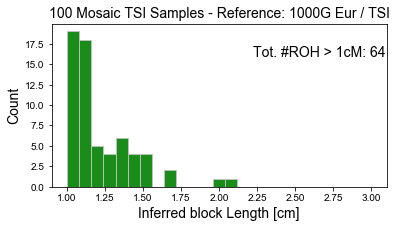

In [20]:
roh = Summary_ROH_Calls(mosaic_folder="./Simulated/1000G_Mosaic/TSI5/", ch=3, nr_iid = 40, 
                        blen_cm = 0, output_prefix = "0999/")
df_call_fp = roh.collect_fp_df()
false_power_statistics(df_call_fp)  # Do give some written statistics
plot_fp_distribution(df_call_fp, title = "100 Mosaic TSI Samples - Reference: 1000G Eur / TSI",
                    figsize=(6,3))

# Plot bias/power/se/fp rate

In [3]:
def load_line_search(cutoffs=[], mosaic_folder = "./Simulated/1000G_Mosaic/TSI6/",
                    ch=3, nr_iid=20, blen_cm=4, min_overlap=0.8, savepath=""):
    """Load Line and Return Line Search Statistics
    for posterior"""
    
    pfixes = [str(c).replace(".", "") + "/" for c in cutoffs]
    n = len(pfixes)
    sts = np.zeros(n, dtype="float")
    fps = np.zeros(n, dtype="float")
    fps2 = np.zeros(n, dtype="float")
    power = np.zeros(n, dtype="float")
    bias = np.zeros(n, dtype="float")
    
    for i,p in enumerate(pfixes):
        output_prefix= pfixes[i]
        roh = Summary_ROH_Calls(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, blen_cm = blen_cm, 
                                output_prefix = output_prefix)

        df_calls = roh.collect_power_df()
        bias[i] = np.mean(df_calls["CalledLength"] - df_calls["OriginalLength"])
        power[i] = np.mean(df_calls["OverlapFrac"] > min_overlap)
        calc_power(df_calls)
        sts[i] = give_SE(df_calls)
        roh = Summary_ROH_Calls(mosaic_folder = mosaic_folder, ch=3, nr_iid = nr_iid, blen_cm = 0, 
                                output_prefix = output_prefix, output=False)
        df_call_fp = roh.collect_fp_df()
        fps[i] = len(df_call_fp)/nr_iid
        fps2[i] = np.sum(df_call_fp["lengthM"]>0.02)/nr_iid
        
    ### Put into 1 Dataframe
    df = pd.DataFrame({"Posterior Cutoff":cutoffs, "Replicates":nr_iid, "STD. Length Called 4cM":sts, 
                       "False Positive ROH>1cM / Chr. 3":fps,
                       "False Positive ROH>2cM / Chr. 3": fps2,
                       "Avg. Length Bias 4 cM [cM]":bias, "Fraction of 80% of 4 cM Block detected":power})
    
    if len(savepath)>0:
        df.to_csv(savepath, index=False)
        print(f"Saved Output Table to {savepath}")
    return df

### The worst case [0.5x PH, 1% error]

In [7]:
#cutoffs = [0.9, 0.99, 0.992, 0.994, 0.996, 0.998, 0.999, 0.9999, 0.99999]
#cutoffs = [0.99, 0.992, 0.994, 0.996, 0.998]
cutoffs = [0.996, 0.997, 0.998, 0.999]
df = load_line_search(cutoffs, mosaic_folder = "./Simulated/1000G_Mosaic/TSI6/",
                      ch=3, nr_iid=100, blen_cm=4, min_overlap=0.8,
                      savepath = "./TablesOut/var_post_cutoff.csv") #

Saved Output Table to ./TablesOut/var_post_cutoff.csv


In [8]:
df

,Posterior Cutoff,Replicates,STD. Length Called 4cM,False Positive ROH>1cM / Chr. 3,False Positive ROH>2cM / Chr. 3,Avg. Length Bias 4 cM [cM],Fraction of 80% of 4 cM Block detected
0,0.996,100,0.614047,5.39,0.47,0.063425,0.958
1,0.997,100,0.586604,4.70,0.35,0.017201,0.950
2,0.998,100,0.571853,3.78,0.21,-0.032272,0.930
3,0.999,100,0.609868,2.34,0.11,-0.171452,0.874


### The best case

In [4]:
cutoffs = [0.998, 0.999, 0.9995]
df = load_line_search(cutoffs, mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/",
                      ch=3, nr_iid=40, blen_cm=4, min_overlap=0.8,
                      savepath = "./TablesOut/var_post_cutoff_bestcase.csv")

Saved Output Table to ./TablesOut/var_post_cutoff_bestcase.csv


In [8]:
df

,Posterior Cutoff,Replicates,STD. Length Called 4cM,False Positive ROH>1cM / Chr. 3,False Positive ROH>2cM / Chr. 3,Avg. Length Bias 4 cM [cM],Fraction of 80% of 4 cM Block detected
0,0.9980,40,0.395002,2.925,0.050,0.091163,0.985
1,0.9990,40,0.381483,1.600,0.025,0.029897,0.975
2,0.9995,40,0.418690,1.000,0.000,-0.048573,0.945


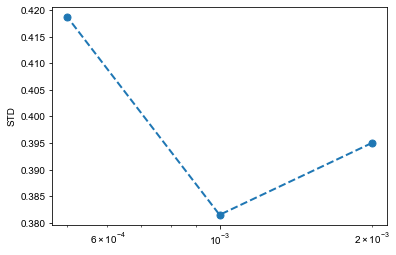

In [6]:
plt.figure()
ax=plt.gca()
ax.plot(1-df["Posterior Cutoff"], df["STD. Length Called 4cM"], "o--", ms=7, lw=2)
ax.set_xscale("log")
ax.set_ylabel("STD")
plt.show()